In [1]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision.models import resnet50,ResNet50_Weights

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


In [2]:
model = resnet50(weights=ResNet50_Weights.DEFAULT).eval().to(device) 

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/featurize/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s]


In [3]:
from torchvision import transforms

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(512),
                                     # transforms.CenterCrop(512),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [4]:
img_path = 'test_img/cat_dog.jpg'
img_pil = Image.open(img_path)
# img_pil
input_tensor = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
input_tensor.shape

torch.Size([1, 3, 512, 768])

In [5]:
# 如果 targets 为 None，则默认为最高置信度类别
targets = [ClassifierOutputTarget(281)]

In [6]:
# model
model.layer4[-1]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

In [7]:
model.layer1[0]

Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [9]:
from pytorch_grad_cam import GradCAM, HiResCAM, GradCAMElementWise, GradCAMPlusPlus, XGradCAM, AblationCAM, ScoreCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad
# Grad-CAM
from pytorch_grad_cam import GradCAM
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

In [10]:
#cam_map = cam(input_tensor=input_tensor, targets=targets)[0] # 不加平滑
cam_map = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True, eigen_smooth=True)[0] # 加平滑

In [11]:
cam_map.shape

(512, 768)

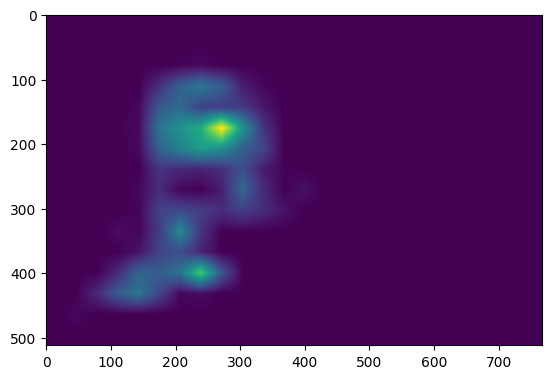

In [12]:
plt.imshow(cam_map)
plt.show()

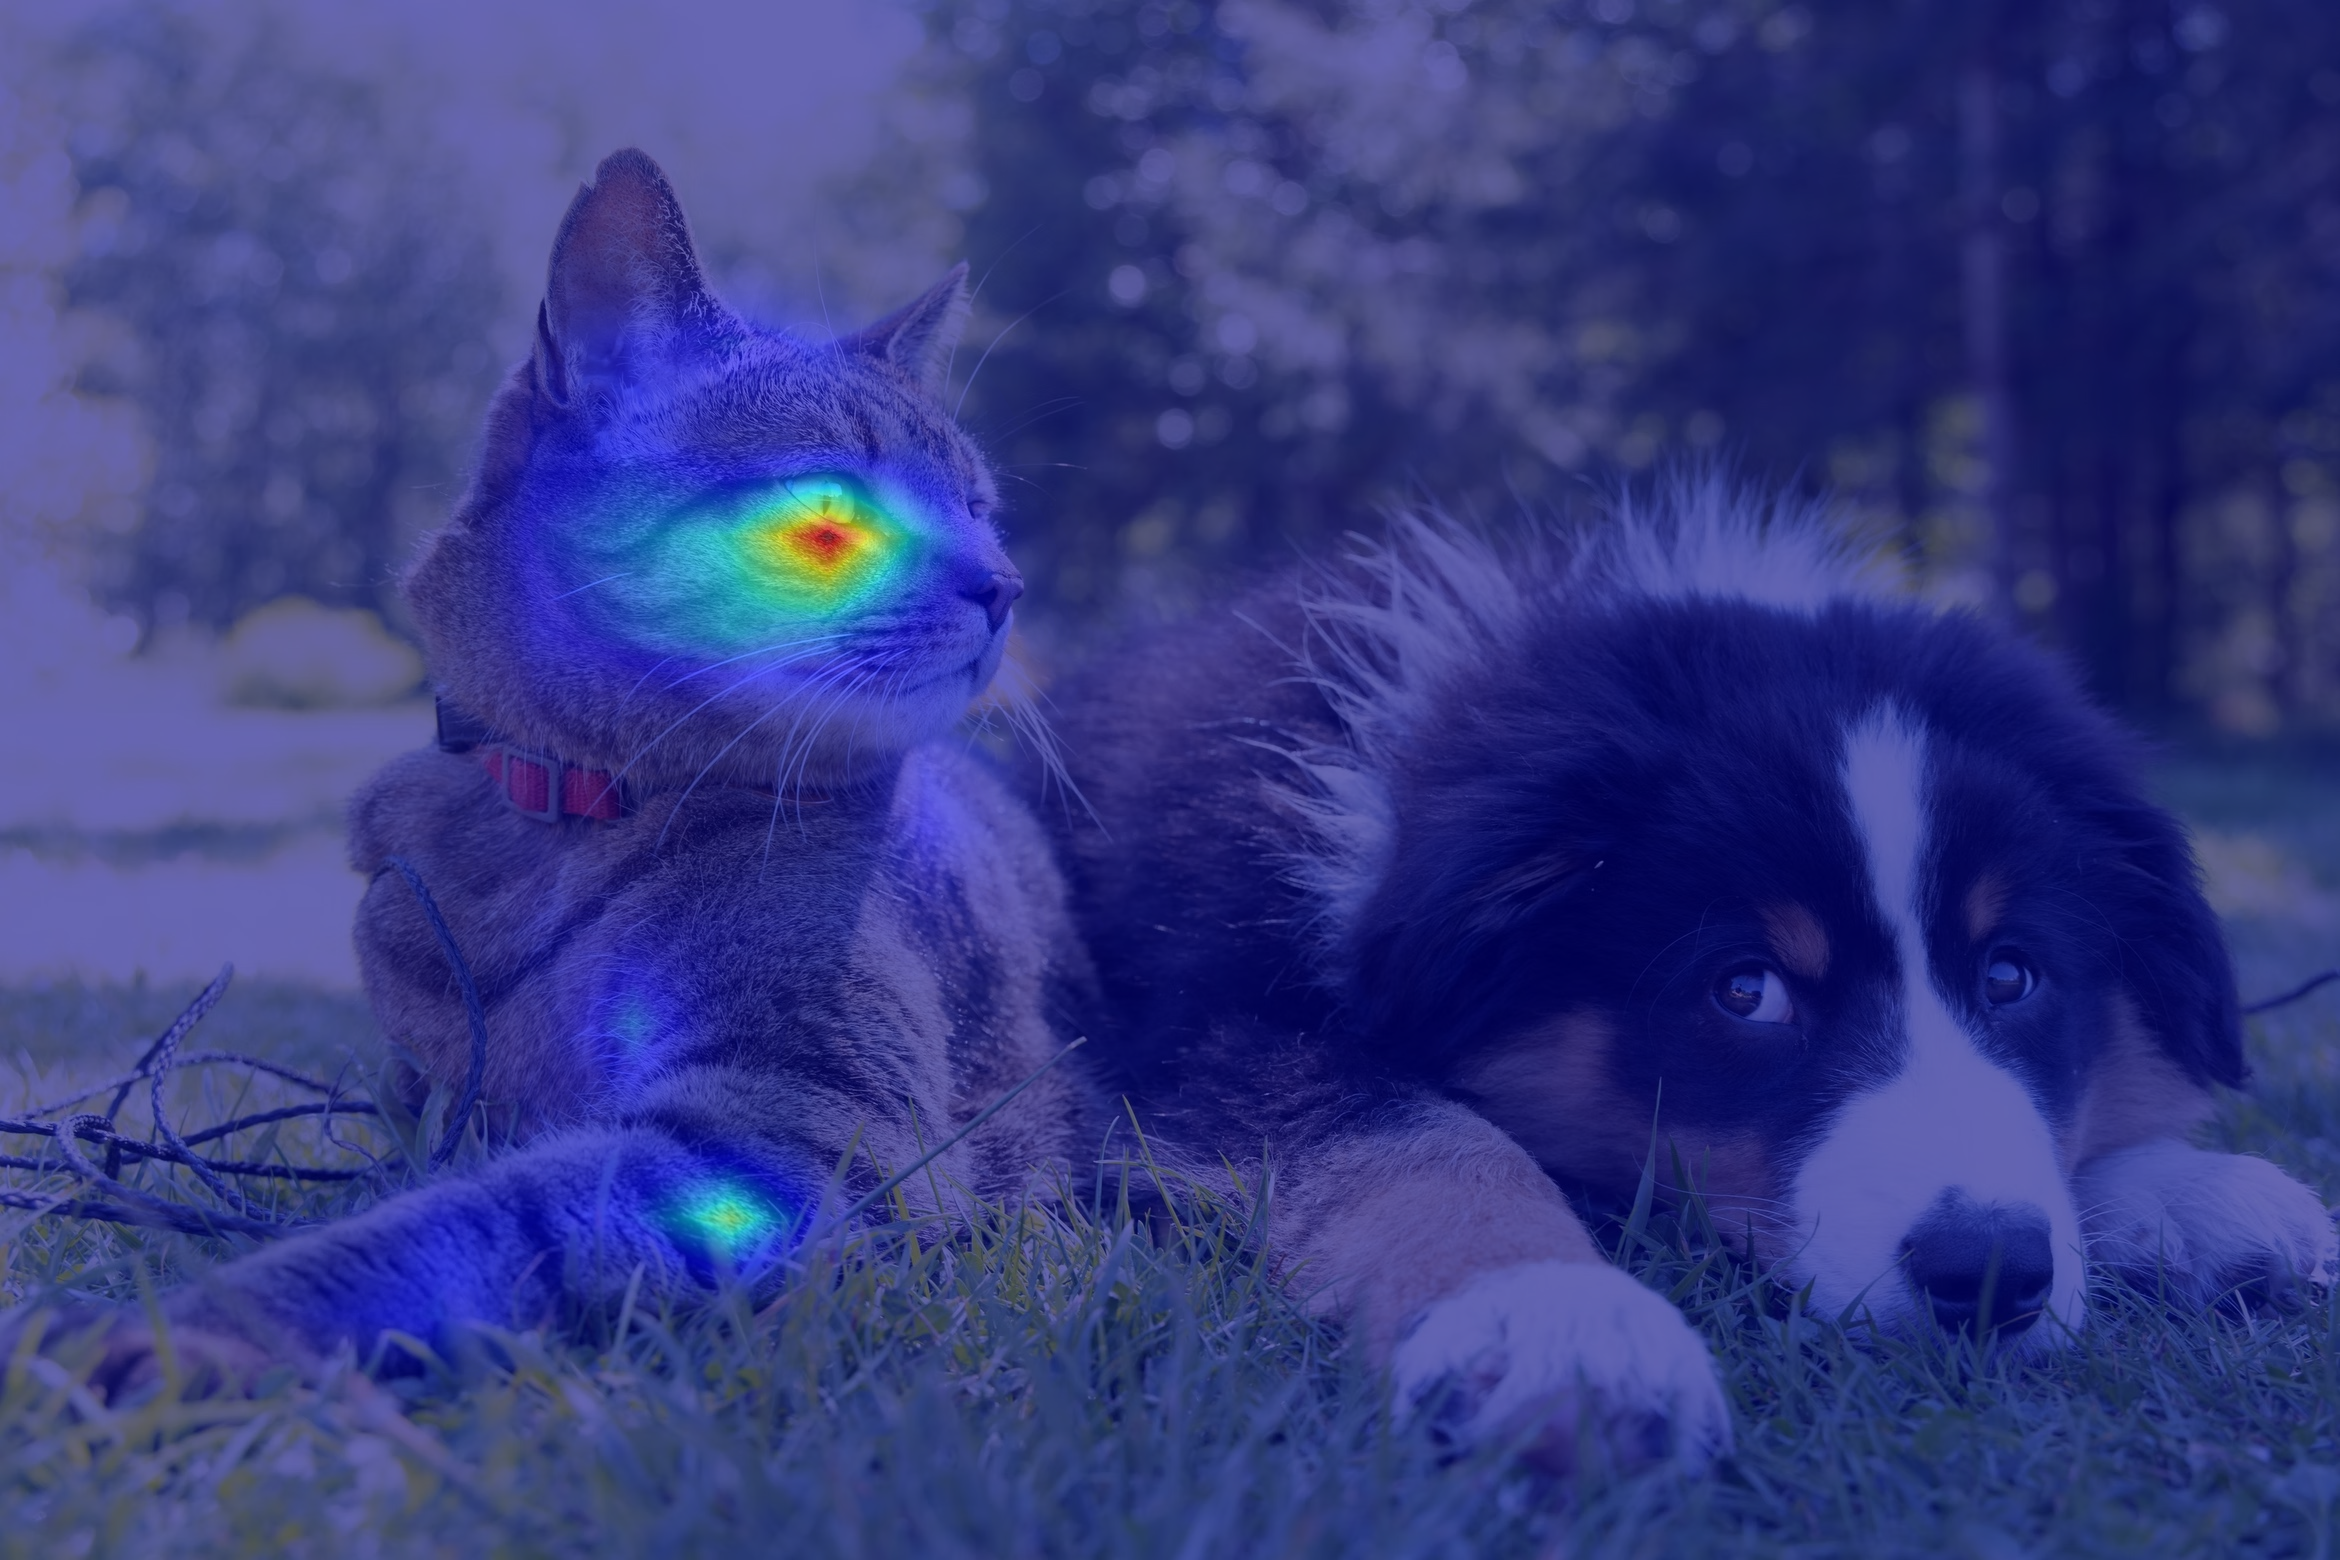

In [13]:
import torchcam
from torchcam.utils import overlay_mask

result = overlay_mask(img_pil, Image.fromarray(cam_map), alpha=0.4) # alpha越小，原图越淡
result

In [14]:
result.save('output/B1.jpg')